In [1]:
import json
import sys
import os
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Add the parent directory (which contains 'office') to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from office.delivery_env import DeliveryRobotEnv


pygame 2.6.1 (SDL 2.28.4, Python 3.10.16)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def draw_trajectory(json_path, use_next_state=False):
    if not json_path.endswith(".json"):
        return

    is_env_config = os.path.basename(json_path) == "env_config.json"

    if is_env_config:
        # Load env config from file and build the environment accordingly
        with open(json_path, "r") as f:
            config_data = json.load(f)
        from office.components.env_configs import get_config
        from util.helpers import make_env

        env = make_env(
            env_config=get_config(config_data["env_name"]),
            render_mode="human",
            show_walls=config_data["show_walls"],
            show_obstacles=config_data["show_obstacles"],
            show_carpets=config_data["show_carpets"],
            use_flashlight=config_data["use_flashlight"],
            use_raycasting=config_data["use_raycasting"]
        )
        positions = None
        alphas = None
    else:
        # Load transitions
        with open(json_path, "r") as f:
            transitions = json.load(f)

        key = "next_state" if use_next_state else "state"
        positions = np.array([step[key][:2] for step in transitions])
        positions[:, 0] *= 800
        positions[:, 1] *= 600
        num_steps = len(positions)
        alphas = np.linspace(0.2, 1.0, num_steps)

        # Load default env (or infer from elsewhere)
        env = DeliveryRobotEnv(
            config="open_office_simple", show_walls=True, show_obstacles=True, show_carpets=False, render_mode="human"
        )

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_facecolor((55 / 255, 55 / 255, 55 / 255))
    ax.set_xlim(0, 800)
    ax.set_ylim(0, 600)
    ax.invert_yaxis()
    ax.set_aspect("equal")
    ax.set_title("Environment" if is_env_config else "Trajectory")

    # Draw static features
    for wall in env.walls:
        ax.add_patch(patches.Rectangle((wall[0], wall[1]), wall[2], wall[3], facecolor="white"))

    for obs in env.obstacles:
        ax.add_patch(patches.Circle((obs[0], obs[1]), obs[2], facecolor=(1, 0.6, 0.6), edgecolor="red", linewidth=2))

    for i, table in enumerate(env.tables):
        tx, ty, tw, th = table
        is_delivered = i in env.delivered_tables
        color = "green" if is_delivered else "orange"
        ax.add_patch(patches.Rectangle((tx, ty), tw, th, facecolor=color, edgecolor="black", linewidth=2))
        if not is_delivered:
            margin = env.robot_radius * 4
            ax.add_patch(patches.Rectangle((tx - margin, ty - margin), tw + 2 * margin, th + 2 * margin,
                                           facecolor=(0, 1, 0, 0.25), linewidth=0))

    # Optional: Draw trajectory if not env_config
    if positions is not None:
        for i in range(1, len(positions)):
            x_vals = positions[i - 1 : i + 1, 0]
            y_vals = positions[i - 1 : i + 1, 1]
            ax.plot(x_vals, y_vals, color="blue", alpha=alphas[i], linewidth=2)

        # Final robot dot
        robot_dot = patches.Circle((positions[-1][0], positions[-1][1]), radius=6, color=(0, 100 / 255, 1))
        ax.add_patch(robot_dot)

    plt.show()
    env.close()

1
trajectory: 0


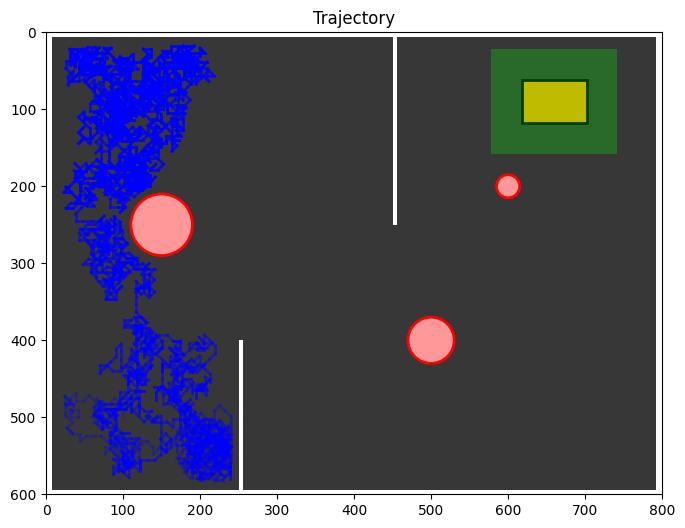

In [4]:
len_logs = len(os.listdir("../logs"))
print(len_logs - 2)
for i in range(len_logs):
    if i % 10 == 0:
        print(f"trajectory: {i}")
        draw_trajectory(f"../logs/episode_{i}.json")

In [4]:


# def animate_trajectory(json_path, use_next_state=False):
#     # Load transitions
#     with open(json_path, "r") as f:
#         transitions = json.load(f)
        
#     # Check if it's a valid trajectory (skip silently if not)
#     if os.path.basename(json_path) == "env_config.json":
#         return

#     key = "next_state" if use_next_state else "state"
#     positions = np.array([step[key][:2] for step in transitions])
#     positions[:, 0] *= 800
#     positions[:, 1] *= 600
#     num_steps = len(positions)
#     alphas = np.linspace(0.2, 1.0, num_steps)

#     # Load env (for static layout)
#     env = DeliveryRobotEnv(
#         config="open_office_simple", show_walls=True, show_obstacles=False, show_carpets=False, render_mode="rgb_array"
#     )

#     # --- Static shapes: walls, obstacles, tables ---
#     shapes = []

#     for wall in env.walls:
#         shapes.append(
#             dict(
#                 type="rect",
#                 x0=wall[0],
#                 y0=wall[1],
#                 x1=wall[0] + wall[2],
#                 y1=wall[1] + wall[3],
#                 fillcolor="white",
#                 line=dict(width=0),
#             )
#         )

#     for obs in env.obstacles:
#         shapes.append(
#             dict(
#                 type="circle",
#                 x0=obs[0] - obs[2],
#                 y0=obs[1] - obs[2],
#                 x1=obs[0] + obs[2],
#                 y1=obs[1] + obs[2],
#                 fillcolor="rgba(255, 153, 153, 1)",
#                 line=dict(color="red", width=2),
#             )
#         )

#     for i, table in enumerate(env.tables):
#         tx, ty, tw, th = table
#         is_delivered = i in env.delivered_tables
#         color = "green" if is_delivered else "orange"
#         shapes.append(dict(type="rect", x0=tx, y0=ty, x1=tx + tw, y1=ty + th, fillcolor=color, line=dict(color="black", width=2)))
#         if not is_delivered:
#             margin = env.robot_radius * 4
#             shapes.append(
#                 dict(
#                     type="rect",
#                     x0=tx - margin,
#                     y0=ty - margin,
#                     x1=tx + tw + margin,
#                     y1=ty + th + margin,
#                     fillcolor="rgba(0,255,0,0.25)",
#                     line=dict(width=0),
#                 )
#             )

#     # --- Static Trajectory with fading opacity ---
#     path_segments = []
#     for i in range(1, num_steps):
#         seg = go.Scatter(
#             x=[positions[i - 1, 0], positions[i, 0]],
#             y=[positions[i - 1, 1], positions[i, 1]],
#             mode="lines",
#             line=dict(color=f"rgba(0, 0, 255, {alphas[i]:.2f})", width=3),
#             showlegend=False,
#         )
#         path_segments.append(seg)

#     # Plot the static path on top of the environment
#     static_layout = go.Layout(
#         title="Static Trajectory (fading opacity)",
#         xaxis=dict(range=[0, 800], scaleanchor="y"),
#         yaxis=dict(range=[600, 0]),  # Inverted y-axis
#         shapes=shapes,
#         width=800,
#         height=600,
#     )
#     static_fig = go.Figure(data=path_segments, layout=static_layout)
#     static_fig.show()  # <- This shows the static figure first

#     # --- Animation ---
#     frames = []
#     for step in range(1, num_steps):
#         path_trace = go.Scatter(
#             x=positions[: step + 1, 0], y=positions[: step + 1, 1], mode="lines", line=dict(color="blue", width=3), opacity=1.0
#         )
#         robot_dot = go.Scatter(
#             x=[positions[step, 0]],
#             y=[positions[step, 1]],
#             mode="markers",
#             marker=dict(size=10, color="deepskyblue"),
#             name="Robot",
#         )
#         frames.append(go.Frame(data=[path_trace, robot_dot], name=str(step)))

#     init_trace = go.Scatter(
#         x=positions[:2, 0], y=positions[:2, 1], mode="lines", line=dict(color="blue", width=3), opacity=1.0, name="Trajectory"
#     )
#     init_dot = go.Scatter(
#         x=[positions[1, 0]], y=[positions[1, 1]], mode="markers", marker=dict(size=10, color="deepskyblue"), name="Robot"
#     )

#     layout = go.Layout(
#         title="Trajectory (Animated)",
#         xaxis=dict(range=[0, 800], scaleanchor="y"),
#         yaxis=dict(range=[600, 0]),
#         shapes=shapes,
#         width=800,
#         height=600,
#         sliders=[
#             dict(
#                 steps=[
#                     dict(
#                         method="animate",
#                         args=[[str(i)], dict(mode="immediate", frame=dict(duration=0), transition=dict(duration=0))],
#                         label=str(i),
#                     )
#                     for i in range(1, num_steps)
#                 ],
#                 transition=dict(duration=0),
#                 x=0.1,
#                 len=0.9,
#             )
#         ],
#         updatemenus=[
#             dict(
#                 type="buttons",
#                 showactive=False,
#                 buttons=[dict(label="Play", method="animate", args=[None, dict(frame=dict(duration=50), fromcurrent=True)])],
#                 x=0.1,
#                 y=-0.05,
#             )
#         ],
#     )

#     animated_fig = go.Figure(data=[init_trace, init_dot], layout=layout, frames=frames)
#     animated_fig.show()

#     env.close()

# # animate_trajectory("../logs/episode_3.json")